In [570]:
import pandas as pd
from scipy.stats import binom_test, fisher_exact
from genepy.utils import helper as h 
%load_ext autoreload
%autoreload 2
%load_ext rpy2.ipython

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


## Processing the data

In [4]:
project='FishSuperResColoc'
version='v2'

In [609]:
rename = {
"Text Between Delimiters":"subset",
"Folder Short":"folder_short",
"Folder Path":"folder",
"Source.Name":"name",
"ImageDocumentName::Image Name":"image",
"ParentID::ID of the parent!!I":"parent_id",
"ID::ID!!I":"id",
"RegionsCount::Count!!I": "count",
"ImageSceneName::Image Scene Name ":"scene",
"Area1::Area Unscaled!!R":"area_u",
"Area::Area!!R": "area",
"CenterX1::Center X Unscaled!!R":"x",
"CenterY1::Center Y Unscaled!!R":"y",
"ImageScaleX::Image Scale X!!R":"scale_x",
"ImageScaleY::Image Scale Y!!R":"scale_y",
"ImageIndexZ::Image Index Z!!I":"z",
'Classes 5 RegionsCount ::Classes 5 Count!!I':"count_red",
'Classes 9 RegionsCount ::Classes 9 Count!!I':"count_green",
"ClassColorName::Region Class Color Name": "class",
"IntensityMaximum_TV1-T1-SR::Intensity Maximum of channel 'TV1-T1-SR'!!R":"max_red",
"IntensityMaximum_TV2-T1-SR::Intensity Maximum of channel 'TV2-T1-SR'!!R":"max_tv2_t1",
"IntensityMaximum_TV2-T2-SR::Intensity Maximum of channel 'TV2-T2-SR'!!R":"max_green",
"IntensityMaximum_TV2-T3-SR::Intensity Maximum of channel 'TV2-T3-SR'!!R":"max_dapi",
"IntensityMean_TV1-T1-SR::Intensity Mean Value of channel 'TV1-T1-SR'!!R":"mean_red",
"IntensityMean_TV2-T1-SR::Intensity Mean Value of channel 'TV2-T1-SR'!!R":"mean_tv2_t1",
"IntensityMean_TV2-T2-SR::Intensity Mean Value of channel 'TV2-T2-SR'!!R":"mean_green",
"IntensityMean_TV2-T3-SR::Intensity Mean Value of channel 'TV2-T3-SR'!!R":"mean_dapi",
"IntensityMinimum_TV1-T1-SR::Intensity Minimum of channel 'TV1-T1-SR'!!R":"min_red",
"IntensityMinimum_TV2-T1-SR::Intensity Minimum of channel 'TV2-T1-SR'!!R":"min_tv2_t1",
"IntensityMinimum_TV2-T2-SR::Intensity Minimum of channel 'TV2-T2-SR'!!R":"min_green",
"IntensityMinimum_TV2-T3-SR::Intensity Minimum of channel 'TV2-T3-SR'!!R":"min_dapi",
"IntensitySum0_TV1-T1-SR::Intensity Pixel Count of channel 'TV1-T1-SR'!!R":"pixsum_red",
"IntensitySum0_TV2-T1-SR::Intensity Pixel Count of channel 'TV2-T1-SR'!!R":"pixsum_tv2_t1",
"IntensitySum0_TV2-T2-SR::Intensity Pixel Count of channel 'TV2-T2-SR'!!R":"pixsum_green",
"IntensitySum0_TV2-T3-SR::Intensity Pixel Count of channel 'TV2-T3-SR'!!R":"pixsum_dapi",
"IntensityRange_TV1-T1-SR::Intensity Range of channel 'TV1-T1-SR'!!R":"range_red",
"IntensityRange_TV2-T1-SR::Intensity Range of channel 'TV2-T1-SR'!!R":"range_tv2_t1",
"IntensityRange_TV2-T2-SR::Intensity Range of channel 'TV2-T2-SR'!!R":"range_green",
"IntensityRange_TV2-T3-SR::Intensity Range of channel 'TV2-T3-SR'!!R":"range_dapi",
"IntensityStd_TV1-T1-SR::Intensity Standard Deviation of channel 'TV1-T1-SR'!!R":"std_red",
"IntensityStd_TV2-T1-SR::Intensity Standard Deviation of channel 'TV2-T1-SR'!!R":"std_tv2_t1",
"IntensityStd_TV2-T2-SR::Intensity Standard Deviation of channel 'TV2-T2-SR'!!R":"std_green",
"IntensityStd_TV2-T3-SR::Intensity Standard Deviation of channel 'TV2-T3-SR'!!R":"std_dapi",
"IntensitySum1_TV1-T1-SR::Intensity Sum of channel 'TV1-T1-SR'!!R":"sum_red",
"IntensitySum1_TV2-T1-SR::Intensity Sum of channel 'TV2-T1-SR'!!R":"sum_tv2_t1",
"IntensitySum1_TV2-T2-SR::Intensity Sum of channel 'TV2-T2-SR'!!R":"sum_green",
"IntensitySum1_TV2-T3-SR::Intensity Sum of channel 'TV2-T3-SR'!!R":"sum_dapi",
"IntensitySum2_TV1-T1-SR::Intensity Sum Squares of channel 'TV1-T1-SR'!!R":"sum2_red",
"IntensitySum2_TV2-T1-SR::Intensity Sum Squares of channel 'TV2-T1-SR'!!R":"sum2_tv2_t1",
"IntensitySum2_TV2-T2-SR::Intensity Sum Squares of channel 'TV2-T2-SR'!!R":"sum2_green",
"IntensitySum2_TV2-T3-SR::Intensity Sum Squares of channel 'TV2-T3-SR'!!R":"sum2_dapi",
"Unnamed: 27":"unknown"
}

In [80]:
data = pd.read_csv('../data/'+project+'/data_query_files/querry.csv').rename(columns=rename)
data

,subset,folder_short,folder,name,image,parent_id,id,scene,area,x,...,sum_1,sum_2,range_1,range_2,std_1,std_2,sum1_1,sum1_2,sum2_1,sum2_2
0,Subset10,AAVS1_CRISPR_MED1\AAVS1_CRISPR_MED1 Image7\,C:\Users\M232498\Desktop\Ju\GDrive\IF FISH fin...,Image 7_Subset10_Out_Maximum intensity project...,NaN,NaN,NaN,NaN,pixel²,pixel,...,pixel²,pixel²,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown²,Unknown²
1,Subset10,AAVS1_CRISPR_MED1\AAVS1_CRISPR_MED1 Image7\,C:\Users\M232498\Desktop\Ju\GDrive\IF FISH fin...,Image 7_Subset10_Out_Maximum intensity project...,Image 7_Subset10_Out_Maximum intensity project...,14.0,15.0,NaN,7,368.64285714286,...,7,7,1661,4080,547.72403548468,1510.241245314,49094,164490,346117272,3878964986
2,Subset10,AAVS1_CRISPR_MED1\AAVS1_CRISPR_MED1 Image7\,C:\Users\M232498\Desktop\Ju\GDrive\IF FISH fin...,Image 7_Subset10_Out_Maximum intensity project...,Image 7_Subset10_Out_Maximum intensity project...,14.0,16.0,NaN,28,396.21428571429,...,28,28,8089,13818,2760.2006509669,3701.1435641623,123989,523204,754750539,10146373720
3,Subset10,AAVS1_CRISPR_MED1\AAVS1_CRISPR_MED1 Image7\,C:\Users\M232498\Desktop\Ju\GDrive\IF FISH fin...,Image 7_Subset10_Out_Maximum intensity project...,Image 7_Subset10_Out_Maximum intensity project...,14.0,17.0,NaN,13,426.88461538462,...,13,13,4583,6576,1313.3590522016,2101.7813019022,108303,285907,922971237,6340918481
4,Subset10,AAVS1_CRISPR_MED1\AAVS1_CRISPR_MED1 Image7\,C:\Users\M232498\Desktop\Ju\GDrive\IF FISH fin...,Image 7_Subset10_Out_Maximum intensity project...,Image 7_Subset10_Out_Maximum intensity project...,14.0,18.0,NaN,29,340.74137931035,...,29,29,3515,12083,1077.0374837392,3107.8328355138,196046,460225,1357791794,7574132899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
117757,Subset9,IF FISH final\Runx2_excel\,C:\Users\M232498\Desktop\Ju\GDrive\IF FISH fin...,Runx2_488_MYC_FISH_SIM-Orthogonal Projection-0...,Runx2_488_MYC_FISH_SIM-Orthogonal Projection-0...,1.0,23.0,NaN,55230,1146.4196089082,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
117758,Subset9,IF FISH final\Runx2_excel\,C:\Users\M232498\Desktop\Ju\GDrive\IF FISH fin...,Runx2_488_MYC_FISH_SIM-Orthogonal Projection-0...,Runx2_488_MYC_FISH_SIM-Orthogonal Projection-0...,1.0,24.0,NaN,60384,1546.5754835718,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
117759,Subset9,IF FISH final\Runx2_excel\,C:\Users\M232498\Desktop\Ju\GDrive\IF FISH fin...,Runx2_488_MYC_FISH_SIM-Orthogonal Projection-0...,Runx2_488_MYC_FISH_SIM-Orthogonal Projection-0...,1.0,25.0,NaN,48042,2480.9880521211,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
117760,Subset9,IF FISH final\Runx2_excel\,C:\Users\M232498\Desktop\Ju\GDrive\IF FISH fin...,Runx2_488_MYC_FISH_SIM-Orthogonal Projection-0...,Runx2_488_MYC_FISH_SIM-Orthogonal Projection-0...,1.0,26.0,NaN,70306,1932.6927004808,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [87]:
data.columns

Index(['subset', 'folder_short', 'folder', 'name', 'image', 'parent_id', 'id',
       'scene', 'area', 'x', 'y', 'max_1', 'max_2', 'mean_1', 'mean_2',
       'min_1', 'min_2', 'sum_1', 'sum_2', 'range_1', 'range_2', 'std_1',
       'std_2', 'sum1_1', 'sum1_2', 'sum2_1', 'sum2_2'],
      dtype='object')

In [5]:
cat ../data/$project/data_query_files/querry.csv | less

<U+FEFF>Text Between Delimiters,Folder Short,Folder Path,Source.Name,ImageDocumentName::Image Name,ParentID::ID of the parent!!I,ID::ID!!I,ImageSceneName::Image Scene Name ,Area1::Area Unscaled!!R,CenterX1::Center X Unscaled!!R,CenterY1::Center Y Unscaled!!R,IntensityMaximum_TV1-T1-SR::Intensity Maximum of channel 'TV1-T1-SR'!!R,IntensityMaximum_TV2-T1-SR::Intensity Maximum of channel 'TV2-T1-SR'!!R,IntensityMean_TV1-T1-SR::Intensity Mean Value of channel 'TV1-T1-SR'!!R,IntensityMean_TV2-T1-SR::Intensity Mean Value of channel 'TV2-T1-SR'!!R,IntensityMinimum_TV1-T1-SR::Intensity Minimum of channel 'TV1-T1-SR'!!R,IntensityMinimum_TV2-T1-SR::Intensity Minimum of channel 'TV2-T1-SR'!!R,IntensitySum0_TV1-T1-SR::Intensity Pixel Count of channel 'TV1-T1-SR'!!R,IntensitySum0_TV2-T1-SR::Intensity Pixel Count of channel 'TV2-T1-SR'!!R,IntensityRange_TV1-T1-SR::Intensity Range of channel 'TV1-T1-SR'!!R,IntensityRange_TV2-T1-SR::Intensity Range of channel 'TV2-T1-SR'!!R,IntensityStd_TV1-T1-SR::Int

In [ ]:
data.iloc[0].tolist()

In [ ]:
set(data.folder_short)

In [ ]:
cond = {'AAVS1_CRISPR_MED1\\AAVS1_CRISPR_MED1 Image7\\':'AAVS1',
 'IF FISH final\\AAVS1_CRISPR_MEF2D\\':'AAVS1',
 'IF FISH final\\IRF2BP2_excel\\':'',
 'IF FISH final\\MEF2C_excel\\':'',
 'IF FISH final\\MEF2D_CRISPR_MED1\\':'MEF2D',
 'IF FISH final\\MEF2D_CRISPR_MEF2D\\':'MEF2D',
 'IF FISH final\\Runx2_excel\\':''}

In [ ]:
prot = {'AAVS1_CRISPR_MED1\\AAVS1_CRISPR_MED1 Image7\\':'MED1',
 'IF FISH final\\AAVS1_CRISPR_MEF2D\\':'MEF2D',
 'IF FISH final\\IRF2BP2_excel\\':'IRF2BP2',
 'IF FISH final\\MEF2C_excel\\':'MEF2C',
 'IF FISH final\\MEF2D_CRISPR_MED1\\':'MED1',
 'IF FISH final\\MEF2D_CRISPR_MEF2D\\':'MEF2D',
 'IF FISH final\\Runx2_excel\\':'RUNX2'}

In [ ]:
data = data[~data.name.str.contains('Classes')]

In [ ]:
data['condition'] = [cond[i] for i in data.folder_short]

In [ ]:
data['protein'] = [prot[i] for i in data.folder_short]

In [ ]:
data['type'] = [i.split('.')[0].split('_')[-1] for i in data.name]

In [ ]:
data['name'] = [cond[i]+'_'+prot[i] for i in data.folder_short]

In [ ]:
set(data.type)

In [ ]:
data = data[~data.id.isna()]

In [ ]:
set(data.subset)

In [ ]:
data = data.drop(columns=['scene','image','folder','folder_short'])

In [ ]:
data['subset'] = [i.split('Subset')[-1] for i in data.subset]

In [ ]:
for val in ['area','x','y','max_1','max_2','mean_1','mean_2','min_1','min_2','range_1','range_2','std_1','std_2','sum_1','sum_2','sum1_1','sum1_2','sum2_1','sum2_2']:
    data[val]= data[val].astype(float)

In [ ]:
for val in ['subset','parent_id','id']:
    data[val] = data[val].astype('int')

In [ ]:
len(data.id)

# results

## why we are not doing a monte carlo but just a hypthesis testing on a binomial

monte carlo would be useful in our case if we did not know the expected distribution.
given a way to generate our distribution (which specific parameters can be learnt from the data) we might be able to express what would be the null hypothesis by estimating this unknown distribution. it is useful for when we don't know the exact distribution or when it is too complex to analytically solve.  

However in our case we can approximate the distribution well enough by a binomial. It is true that given that the dna will not have the same density everywhere on the nucleus, that the dots will have themselves variable intensity and size, which might express or not a multiplicity of points, the distribution is not a binomial. 

But you said yourself that for all purposes we could simplify these hypothesis. 

I also don't think that we have enough data points to correctly estimate the monte carlo parameters. 

A binomial is thus enough for this analysis

### having specificities in the data needing to be modelled:

I found that the data has specific bias that still need to be taken in account while not needing to change the statistics:

the avg size of a MYC dot is 350 whereas the one of a MYC green is 45

In [ ]:
def desc(data):
    return data.sum()/data.mean(),len(data)
# for each group
res = {}
for val in set(data.name):
    print('\n',val)
    group = data[data.name==val]
    space = group[group.type=='Nucleus'].area.sum()
    totsize = group[group.type==' Green Dots'].area.sum()
                 
    coloc,s_coloc = desc(group[group.type=='MYC  Green'].area)
    outside,s_outside = desc(group[group.type=='MYC'].area)
    print('data: \n  - total nucleuses size: '+str(int(space))+'\n  - total Green dot size: '+str(int(totsize))+'\n  - counts for coloc: '+str(int(s_coloc))+'\n  - counts for not coloc: '+str(int(s_outside))) 
    p_in = totsize/space
    isin = coloc/(outside+coloc)
    res[val] = [s_coloc,s_outside]
    print('proba: (null, obs)',p_in,isin)
    print('nb of datapoints: ',s_coloc+s_outside)
    print('p_value: ',binom_test([s_coloc,s_outside],p=p_in))

from this analysis it seems clear that the colocalization happens less than 50% of the time in any condition but that we have colocalization with MYC for all analyzed proteins compared to random chance, given the data extracted by the algorithm and the assumption we made.

In [ ]:
fisher_exact([res['AAVS1_MED1'], res['MEF2D_MED1']])

In [ ]:
fisher_exact([res['AAVS1_MEF2D'], res['MEF2D_MEF2D']])

we thus have much 1.7 times more colocalization of MEF2D when MEF2D is degraded vs when it is not and 2 times less colocalization of MED1 but p_val of .1

## running new version

In [ ]:
TODO: compare intensities & areas between conditions

In [12]:
project='FishSuperResColoc'
version='v2'

In [667]:
csvs = ! ls ../data/$project/Yaser_analysis/Tables*/*/*.csv
res = pd.DataFrame()
for val in csvs:
    v = pd.read_csv(val,).drop(index=0)
    v['filename'] = '-'.join(val.split('/')[-3].split('-')[1:])+"-w"+val.split('/')[-2].split('-')[-2]
    res = res.append(v)
res = res.rename(columns=rename)
res.parent_id = res.parent_id.astype(int)
res.id = res.id.astype(int)
res.area = res.area.astype(float)
res = res.reset_index(drop=True)

/home/jeremie/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (3,4,5,6,8,9,11,12) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
/home/jeremie/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (3,4,5,6,8,9) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [668]:
res["zsize"] = 1

In [669]:
values =  ['area', 'x', 'y', "z", "scale_x", "scale_y", "count_red", "count_green", "max_red", "max_green", "max_dapi", "mean_red", "mean_green", "mean_dapi", "min_red", "min_green", "min_dapi", "pixsum_red", "pixsum_green", "pixsum_dapi", "range_red", "range_green", "range_dapi", "std_red", "std_green", "std_dapi", "sum_red", "sum_green", "sum_dapi", "sum2_red", "sum2_green", "sum2_dapi"]
res[values] = pd.concat([res[i].astype(str).str.replace('  ','0').replace(' ','0').replace('', '0').replace('None',"0").astype(float) for i in values], axis=1)
res['x']= res['x']*res["scale_x"]
res['y']= res['y']*res["scale_y"]
res = res.drop(columns=['area_u',"scale_x",'scale_y'])
set(['-'.join(i.split('/')[-3].split('-')[1:]) for i in csvs])

{'MED1-MYC_MEF2D-DMSOvsVHL',
 'MEF2C-MYC_MEF2D-DMSOvsVHL',
 'MEF2D-MEF2C_DMSOvsVHL'}

TV2-T3: Dapi

TV1-T1: red

TV2-T2: green

In [670]:
res["new_id"]= res['filename'] + "--" + res['image'].str.replace('.czi','').str.replace('Image ','').str.replace('Channel Alignment_P',"")+"--"+res['id'].astype(str)+"--"+res['parent_id'].astype(str)

<ipython-input-670-15ff780eabc4>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  res["new_id"]= res['filename'] + "--" + res['image'].str.replace('.czi','').str.replace('Image ','').str.replace('Channel Alignment_P',"")+"--"+res['id'].astype(str)+"--"+res['parent_id'].astype(str)


In [671]:
res['group'] = res['filename'] + "--" + res['image'].str.replace('.czi','').str.replace('Image ','').str.replace('Channel Alignment_P',"")

<ipython-input-671-68139eb8e6db>:1: FutureWarning: The default value of regex will change from True to False in a future version.
  res['group'] = res['filename'] + "--" + res['image'].str.replace('.czi','').str.replace('Image ','').str.replace('Channel Alignment_P',"")


In [672]:
res['parent_id'] = [i.split('--')[-1] for i in res.new_id]
res['exp'] = [i.split('--')[0].split('-w')[0] for i in res.new_id]
res['treat'] = [i.split('--')[0].split('-w')[1] for i in res.new_id]
res['image'] = [i.split('--')[-1].split('_')[0] for i in res.group]
res['part'] = [i.split('_')[-1] for i in res.group]
res['id'] = [i.split('--')[-2] for i in res.new_id]
set(res.exp)

{'MED1-MYC_MEF2D-DMSOvsVHL',
 'MEF2C-MYC_MEF2D-DMSOvsVHL',
 'MEF2D-MEF2C_DMSOvsVHL'}

In [673]:
res['class'] = res['class'].replace({'Orange':"dapi", 'Fuchsia': "green", "White": 'red'})

In [675]:
res = res.drop(index=res[res['class'].isna()].index)

In [676]:
vals=['parent_id',"id","area","x",'y',"z","count_red","count_green"]
res[vals] = res[vals].astype(int)

In [677]:
cells = res[res["parent_id"]==1]
dots = res[res["parent_id"]!=1]
cells[['count_red','count_green']].mean()

count_red      0.028077
count_green    0.056730
dtype: float64

In [702]:
res['id'].max()

2475

In [703]:
len(cells),len(dots)

(604050, 51228)

In [698]:
cells.iloc[:40]

,image,parent_id,id,area,x,y,z,class,count_red,count_green,...,sum2_red,sum2_green,sum2_dapi,filename,zsize,new_id,group,exp,treat,part
0,12,1,2,50953,10420,1019,7,dapi,0,0,...,0.0,0.0,0.0,MEF2C-MYC_MEF2D-DMSOvsVHL-wDMSO,1,MEF2C-MYC_MEF2D-DMSOvsVHL-wDMSO--12_Out_1-1--2--1,MEF2C-MYC_MEF2D-DMSOvsVHL-wDMSO--12_Out_1-1,MEF2C-MYC_MEF2D-DMSOvsVHL,DMSO,1-1
1,12,1,3,35275,10338,1362,7,dapi,0,0,...,0.0,0.0,0.0,MEF2C-MYC_MEF2D-DMSOvsVHL-wDMSO,1,MEF2C-MYC_MEF2D-DMSOvsVHL-wDMSO--12_Out_1-1--3--1,MEF2C-MYC_MEF2D-DMSOvsVHL-wDMSO--12_Out_1-1,MEF2C-MYC_MEF2D-DMSOvsVHL,DMSO,1-1
2,12,1,4,43114,5416,1498,7,dapi,0,0,...,0.0,0.0,0.0,MEF2C-MYC_MEF2D-DMSOvsVHL-wDMSO,1,MEF2C-MYC_MEF2D-DMSOvsVHL-wDMSO--12_Out_1-1--4--1,MEF2C-MYC_MEF2D-DMSOvsVHL-wDMSO--12_Out_1-1,MEF2C-MYC_MEF2D-DMSOvsVHL,DMSO,1-1
3,12,1,5,104846,10090,1973,7,dapi,0,0,...,0.0,0.0,0.0,MEF2C-MYC_MEF2D-DMSOvsVHL-wDMSO,1,MEF2C-MYC_MEF2D-DMSOvsVHL-wDMSO--12_Out_1-1--5--1,MEF2C-MYC_MEF2D-DMSOvsVHL-wDMSO--12_Out_1-1,MEF2C-MYC_MEF2D-DMSOvsVHL,DMSO,1-1
4,12,1,6,28416,12406,1986,7,dapi,0,0,...,0.0,0.0,0.0,MEF2C-MYC_MEF2D-DMSOvsVHL-wDMSO,1,MEF2C-MYC_MEF2D-DMSOvsVHL-wDMSO--12_Out_1-1--6--1,MEF2C-MYC_MEF2D-DMSOvsVHL-wDMSO--12_Out_1-1,MEF2C-MYC_MEF2D-DMSOvsVHL,DMSO,1-1
5,12,1,7,111705,10446,2423,7,dapi,0,0,...,0.0,0.0,0.0,MEF2C-MYC_MEF2D-DMSOvsVHL-wDMSO,1,MEF2C-MYC_MEF2D-DMSOvsVHL-wDMSO--12_Out_1-1--7--1,MEF2C-MYC_MEF2D-DMSOvsVHL-wDMSO--12_Out_1-1,MEF2C-MYC_MEF2D-DMSOvsVHL,DMSO,1-1
6,12,1,8,44094,10032,2860,7,dapi,0,0,...,0.0,0.0,0.0,MEF2C-MYC_MEF2D-DMSOvsVHL-wDMSO,1,MEF2C-MYC_MEF2D-DMSOvsVHL-wDMSO--12_Out_1-1--8--1,MEF2C-MYC_MEF2D-DMSOvsVHL-wDMSO--12_Out_1-1,MEF2C-MYC_MEF2D-DMSOvsVHL,DMSO,1-1
7,12,1,9,19597,8010,3424,7,dapi,0,0,...,0.0,0.0,0.0,MEF2C-MYC_MEF2D-DMSOvsVHL-wDMSO,1,MEF2C-MYC_MEF2D-DMSOvsVHL-wDMSO--12_Out_1-1--9--1,MEF2C-MYC_MEF2D-DMSOvsVHL-wDMSO--12_Out_1-1,MEF2C-MYC_MEF2D-DMSOvsVHL,DMSO,1-1
8,12,1,10,60752,8607,3900,7,dapi,0,0,...,0.0,0.0,0.0,MEF2C-MYC_MEF2D-DMSOvsVHL-wDMSO,1,MEF2C-MYC_MEF2D-DMSOvsVHL-wDMSO--12_Out_1-1--1...,MEF2C-MYC_MEF2D-DMSOvsVHL-wDMSO--12_Out_1-1,MEF2C-MYC_MEF2D-DMSOvsVHL,DMSO,1-1
9,12,1,11,30376,6757,4262,7,dapi,0,0,...,0.0,0.0,0.0,MEF2C-MYC_MEF2D-DMSOvsVHL-wDMSO,1,MEF2C-MYC_MEF2D-DMSOvsVHL-wDMSO--12_Out_1-1--1...,MEF2C-MYC_MEF2D-DMSOvsVHL-wDMSO--12_Out_1-1,MEF2C-MYC_MEF2D-DMSOvsVHL,DMSO,1-1


In [686]:
import matplotlib.pyplot as plt
import seaborn as sns

In [690]:
len(cells[cells.group=="MEF2C-MYC_MEF2D-DMSOvsVHL-wDMSO--12_Out_1-1"][['x','y']])

5938

/home/jeremie/.local/lib/python3.8/site-packages/seaborn/relational.py:885: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  plot_data = self.establish_variables(


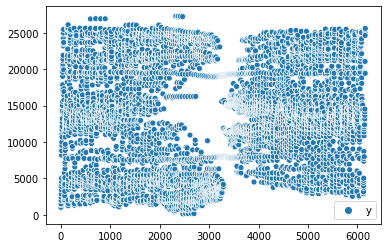

In [689]:
sns.scatterplot(data=cells[cells.group=="MEF2C-MYC_MEF2D-DMSOvsVHL-wDMSO--12_Out_1-1"][['x','y']])

In [482]:
idcount = 0
for group in set(res.group):
    # merging cells
    zcell = cells[(cells.group==group)]
    cid = list(set(zcell.id.astype(int)))
    cpos = [zcell[(zcell.id==str(c))][['x','y']].mean().tolist() for c in cid]
    smaller = np.zeros((len(cid),len(zcell)))
    smaller = np.array([np.sqrt(np.sum((zcell[['x','y']].values - np.array(cpos[i]))**2, 1)) for i in range(len(cid))])
    for i, v in enumerate(np.argmin(smaller, 0)):
        if cid[v] != int(zcell.iloc[i].id):
            print(str(zcell.iloc[i].name)+' is not right')
        oldid = zcell.iloc[i].id
        cells.loc[zcell.iloc[i].name, "id"] = str(cid[v] + idcount)
        # change all dots' parent_id in this cell
        dots.loc[dots[(dots.group==group) & (dots.z == zcell.iloc[i].z) & (dots.parent_id = oldid)].index, 'parent_id'] =  str(cid[v]+idcount)
    idcount += len(cids)

VHL_MEF2D-MYC-wVHL--5_SIM_1-4--2--1 is not right
VHL_MEF2D-MYC-wVHL--5_SIM_1-4--3--1 is not right
VHL_MEF2D-MYC-wVHL--5_SIM_1-4--2--1 is not right
VHL_MEF2D-MYC-wVHL--5_SIM_1-4--3--1 is not right
VHL_MEF2D-MYC-wVHL--5_SIM_1-4--2--1 is not right
VHL_MEF2D-MYC-wVHL--5_SIM_1-4--3--1 is not right
VHL_MEF2D-MYC-wVHL--5_SIM_1-4--2--1 is not right
VHL_MEF2D-MYC-wVHL--5_SIM_1-4--3--1 is not right
VHL_MEF2D-MYC-wVHL--5_SIM_1-4--2--1 is not right
VHL_MEF2D-MYC-wVHL--5_SIM_1-4--3--1 is not right
VHL_MEF2D-MYC-wVHL--5_SIM_1-4--2--1 is not right
VHL_MEF2D-MYC-wVHL--5_SIM_1-4--3--1 is not right
VHL_MEF2D-MYC-wVHL--5_SIM_1-4--2--1 is not right
VHL_MEF2D-MYC-wVHL--5_SIM_1-4--3--1 is not right
VHL_MEF2D-MYC-wVHL--5_SIM_1-4--2--1 is not right
VHL_MEF2D-MYC-wVHL--5_SIM_1-4--3--1 is not right
VHL_MEF2D-MYC-wVHL--5_SIM_1-4--2--1 is not right
VHL_MEF2D-MYC-wVHL--5_SIM_1-4--3--1 is not right
VHL_MEF2D-MYC-wVHL--5_SIM_1-4--2--1 is not right
VHL_MEF2D-MYC-wVHL--5_SIM_1-4--3--1 is not right
VHL_MEF2D-MYC-wVHL--

VHL_MEF2C-MEF2D-wDMSO--8_Out_2-4--3--1 is not right
VHL_MEF2C-MEF2D-wDMSO--8_Out_2-4--3--1 is not right
VHL_MEF2C-MEF2D-wDMSO--8_Out_2-4--3--1 is not right
VHL_MEF2C-MEF2D-wDMSO--8_Out_2-4--3--1 is not right
VHL_MEF2C-MEF2D-wDMSO--8_Out_2-4--3--1 is not right
VHL_MEF2C-MEF2D-wDMSO--8_Out_2-4--3--1 is not right
VHL_MEF2C-MEF2D-wDMSO--8_Out_2-4--3--1 is not right
VHL_MEF2C-MEF2D-wDMSO--8_Out_2-4--3--1 is not right
VHL_MEF2C-MEF2D-wDMSO--8_Out_2-4--3--1 is not right
VHL_MEF2C-MEF2D-wDMSO--8_Out_2-4--3--1 is not right
VHL_MEF2C-MEF2D-wDMSO--8_Out_2-4--3--1 is not right
VHL_MEF2C-MEF2D-wDMSO--8_Out_2-4--3--1 is not right
VHL_MEF2C-MEF2D-wDMSO--8_Out_2-4--3--1 is not right
VHL_MEF2C-MEF2D-wDMSO--8_Out_2-4--3--1 is not right
VHL_MEF2C-MEF2D-wDMSO--8_Out_2-4--3--1 is not right
VHL_MEF2C-MEF2D-wDMSO--8_Out_2-4--3--1 is not right
VHL_MEF2C-MEF2D-wDMSO--8_Out_2-4--3--1 is not right
VHL_MEF2C-MEF2D-wDMSO--8_Out_2-4--3--1 is not right
VHL_MEF2C-MEF2D-wDMSO--8_Out_2-4--3--1 is not right
VHL_MEF2C-ME

VHL_MEF2C-MYC-wDMSO--12_Out_4-1--2--1 is not right
VHL_MEF2C-MYC-wDMSO--12_Out_4-1--2--1 is not right
VHL_MEF2C-MYC-wDMSO--12_Out_4-1--2--1 is not right
VHL_MEF2C-MYC-wDMSO--12_Out_4-1--2--1 is not right
VHL_MEF2C-MYC-wDMSO--12_Out_4-1--2--1 is not right
VHL_MEF2C-MYC-wDMSO--12_Out_4-1--2--1 is not right
VHL_MEF2C-MYC-wDMSO--12_Out_4-1--2--1 is not right
VHL_MEF2C-MYC-wDMSO--12_Out_4-1--2--1 is not right
VHL_MEF2C-MYC-wDMSO--12_Out_4-1--2--1 is not right
VHL_MEF2C-MYC-wDMSO--12_Out_4-1--2--1 is not right
VHL_MEF2C-MYC-wDMSO--12_Out_4-1--2--1 is not right
VHL_MEF2C-MYC-wDMSO--12_Out_4-1--2--1 is not right
VHL_MEF2C-MYC-wDMSO--12_Out_4-1--2--1 is not right
VHL_MEF2C-MYC-wDMSO--12_Out_4-1--2--1 is not right
VHL_MEF2C-MYC-wDMSO--12_Out_4-1--2--1 is not right
VHL_MEF2C-MYC-wDMSO--12_Out_4-1--2--1 is not right
VHL_MEF2C-MYC-wDMSO--12_Out_4-1--2--1 is not right
VHL_MEF2C-MYC-wDMSO--12_Out_4-1--2--1 is not right
VHL_MEF2C-MYC-wDMSO--12_Out_4-1--2--1 is not right
VHL_MEF2C-MYC-wDMSO--12_Out_4-1

VHL_MED1-MYC-wDMSO--13_SIM_2-1--2--1 is not right
VHL_MED1-MYC-wDMSO--13_SIM_2-1--3--1 is not right
VHL_MED1-MYC-wDMSO--13_SIM_2-1--2--1 is not right
VHL_MED1-MYC-wDMSO--13_SIM_2-1--3--1 is not right
VHL_MED1-MYC-wDMSO--13_SIM_2-1--2--1 is not right
VHL_MED1-MYC-wDMSO--13_SIM_2-1--3--1 is not right
VHL_MED1-MYC-wDMSO--13_SIM_2-1--2--1 is not right
VHL_MED1-MYC-wDMSO--13_SIM_2-1--3--1 is not right
VHL_MED1-MYC-wDMSO--13_SIM_2-1--2--1 is not right
VHL_MED1-MYC-wDMSO--13_SIM_2-1--3--1 is not right
VHL_MED1-MYC-wDMSO--13_SIM_2-1--2--1 is not right
VHL_MED1-MYC-wDMSO--13_SIM_2-1--3--1 is not right
VHL_MED1-MYC-wDMSO--13_SIM_2-1--2--1 is not right
VHL_MED1-MYC-wDMSO--13_SIM_2-1--3--1 is not right
VHL_MED1-MYC-wDMSO--13_SIM_2-1--2--1 is not right
VHL_MED1-MYC-wDMSO--13_SIM_2-1--3--1 is not right
VHL_MED1-MYC-wDMSO--13_SIM_2-1--2--1 is not right
VHL_MED1-MYC-wDMSO--13_SIM_2-1--3--1 is not right
VHL_MED1-MYC-wDMSO--13_SIM_2-1--2--1 is not right
VHL_MED1-MYC-wDMSO--13_SIM_2-1--3--1 is not right


VHL_MEF2C-MEF2D-wDMSO--8_Out_2-3--4--1 is not right
VHL_MEF2C-MEF2D-wDMSO--8_Out_2-3--4--1 is not right
VHL_MEF2C-MEF2D-wDMSO--8_Out_2-3--4--1 is not right
VHL_MEF2C-MEF2D-wDMSO--8_Out_2-3--4--1 is not right
VHL_MEF2C-MEF2D-wDMSO--8_Out_2-3--4--1 is not right
VHL_MEF2C-MEF2D-wDMSO--8_Out_2-3--4--1 is not right
VHL_MEF2C-MEF2D-wDMSO--8_Out_2-3--4--1 is not right
VHL_MEF2C-MEF2D-wDMSO--8_Out_2-3--4--1 is not right
VHL_MEF2C-MEF2D-wDMSO--8_Out_2-3--4--1 is not right
VHL_MEF2C-MEF2D-wDMSO--8_Out_2-3--4--1 is not right
VHL_MEF2C-MEF2D-wDMSO--8_Out_2-3--4--1 is not right
VHL_MEF2C-MEF2D-wDMSO--8_Out_2-3--4--1 is not right
VHL_MEF2C-MEF2D-wDMSO--8_Out_2-3--4--1 is not right
VHL_MEF2C-MEF2D-wDMSO--8_Out_2-3--4--1 is not right
VHL_MEF2C-MEF2D-wDMSO--8_Out_2-3--4--1 is not right
VHL_MEF2C-MEF2D-wDMSO--8_Out_2-3--4--1 is not right
VHL_MEF2C-MEF2D-wDMSO--8_Out_2-3--4--1 is not right
VHL_MEF2C-MEF2D-wDMSO--8_Out_2-3--4--1 is not right
VHL_MEF2C-MEF2D-wDMSO--8_Out_2-3--4--1 is not right
VHL_MEF2C-ME

VHL_MEF2C-MYC-wVHL--26_Out_2-2--3--1 is not right
VHL_MEF2C-MYC-wVHL--26_Out_2-2--3--1 is not right
VHL_MEF2C-MYC-wVHL--26_Out_2-2--3--1 is not right
VHL_MEF2C-MYC-wVHL--26_Out_2-2--3--1 is not right
VHL_MEF2C-MEF2D-wDMSO--8_Out_2-1--2--1 is not right
VHL_MEF2C-MEF2D-wDMSO--8_Out_2-1--3--1 is not right
VHL_MEF2C-MEF2D-wDMSO--8_Out_2-1--2--1 is not right
VHL_MEF2C-MEF2D-wDMSO--8_Out_2-1--3--1 is not right
VHL_MEF2C-MEF2D-wDMSO--8_Out_2-1--2--1 is not right
VHL_MEF2C-MEF2D-wDMSO--8_Out_2-1--3--1 is not right
VHL_MEF2C-MEF2D-wDMSO--8_Out_2-1--2--1 is not right
VHL_MEF2C-MEF2D-wDMSO--8_Out_2-1--3--1 is not right
VHL_MEF2C-MEF2D-wDMSO--8_Out_2-1--2--1 is not right
VHL_MEF2C-MEF2D-wDMSO--8_Out_2-1--3--1 is not right
VHL_MEF2C-MEF2D-wDMSO--8_Out_2-1--2--1 is not right
VHL_MEF2C-MEF2D-wDMSO--8_Out_2-1--3--1 is not right
VHL_MEF2C-MEF2D-wDMSO--8_Out_2-1--2--1 is not right
VHL_MEF2C-MEF2D-wDMSO--8_Out_2-1--3--1 is not right
VHL_MEF2C-MEF2D-wDMSO--8_Out_2-1--2--1 is not right
VHL_MEF2C-MEF2D-wDMS

VHL_MEF2D-MYC-wVHL--5_SIM_2-1--2--1 is not right
VHL_MEF2D-MYC-wVHL--5_SIM_2-1--3--1 is not right
VHL_MEF2D-MYC-wVHL--5_SIM_2-1--4--1 is not right
VHL_MEF2D-MYC-wVHL--5_SIM_2-1--2--1 is not right
VHL_MEF2D-MYC-wVHL--5_SIM_2-1--3--1 is not right
VHL_MEF2D-MYC-wVHL--5_SIM_2-1--4--1 is not right
VHL_MEF2D-MYC-wVHL--5_SIM_2-1--2--1 is not right
VHL_MEF2D-MYC-wVHL--5_SIM_2-1--3--1 is not right
VHL_MEF2D-MYC-wVHL--5_SIM_2-1--4--1 is not right
VHL_MEF2D-MYC-wVHL--5_SIM_2-1--2--1 is not right
VHL_MEF2D-MYC-wVHL--5_SIM_2-1--3--1 is not right
VHL_MEF2D-MYC-wVHL--5_SIM_2-1--4--1 is not right
VHL_MEF2D-MYC-wVHL--5_SIM_2-1--4--1 is not right
VHL_MEF2D-MYC-wVHL--5_SIM_2-1--4--1 is not right
VHL_MEF2D-MYC-wVHL--5_SIM_2-1--4--1 is not right
VHL_MEF2D-MYC-wVHL--5_SIM_2-1--2--1 is not right
VHL_MEF2D-MYC-wVHL--5_SIM_2-1--3--1 is not right
VHL_MEF2D-MYC-wVHL--5_SIM_2-1--4--1 is not right
VHL_MEF2D-MYC-wVHL--5_SIM_2-1--2--1 is not right
VHL_MEF2D-MYC-wVHL--5_SIM_2-1--3--1 is not right
VHL_MEF2D-MYC-wVHL--

In [497]:
from collections import Counter

In [500]:
set(Counter([1,2,3,3,4]).values())

{1, 2}

In [ ]:
pixsize = 20 # size of a pixel in nm

In [533]:
# do the same for dots
maxid = 0
for group in set(res.group):
    
    # merging cells
    gdots = dots[(dots.group==group)]
    cid = list(set(gdots.id.astype(int)))
    
    # unique ids
    for c in ['likely_green', "likely_red"]:
        prevzdots = False
        for z in set(gdots.z):
            zdots = gdots[(gdots.z==z) & gdots[c]]
            if len(set(Counter(zdots.id).values())) > 2:
                raise ValueError('multiple of the same id', z, group, Counter(zdots.id))
            
            if prevzdots:
                smaller = np.array([np.sqrt(np.sum((zdots[['x','y']].values - np.array(val))**2, 1)) for val in prevzdots[['x','y']].values])
                rad = np.sqrt(zdots.area/3.14)/pixsize

                smallerloc = np.argmin(smaller, 0)
                prevdotsloc = np.argwhere(smaller[smallerloc]<rad*2)
                newdotsloc = np.argwhere(smaller[smallerloc]>=rad*2)
                
                # we reassign right ids:
                dots.loc[zdots.iloc[prevdotsloc].index, 'id'] = prevzdots.iloc[smallerloc].id.tolist()
                
                #we create new ids:
                dots.loc[zdots.iloc[newdotsloc].index, 'id'] = range(maxid, len(newdotsloc) + maxid)
                maxid += len(newdotsloc) 
            else:
                prevzdots = zdots.copy()
                maxid = max(zdots.id) if maxid==0 else len(zdots.id) + maxid

ValueError: ('multiple of the same id', 0.0, 'VHL_MEF2D-MYC-wVHL--5_SIM_1-4', Counter({7: 25, 8: 11, 9: 11, 10: 7, 11: 3, 12: 1}))

In [569]:
dots[(dots.id==10)&(dots.group=="VHL_MEF2D-MYC-wVHL--5_SIM_1-4")&(dots.likely_green)]

,image,parent_id,id,area,x,y,z,count_red,count_green,max_red,...,sum_green,sum_dapi,sum2_red,sum2_green,sum2_dapi,filename,zsize,group,likely_green,likely_red
3359,Image 5_SIM_Channel Alignment_P1-4.czi,9,10,27436.491004,421.392857,369.357143,0.0,0.0,0.0,215.0,...,43747.0,16318.0,275995.0,70211141.0,19668578.0,VHL_MEF2D-MYC-wVHL,1,VHL_MEF2D-MYC-wVHL--5_SIM_1-4,1.0,0.0
3364,Image 5_SIM_Channel Alignment_P1-4.czi,9,10,40174.861827,421.426829,368.426829,0.0,0.0,0.0,215.0,...,68819.0,20085.0,251952.0,123563765.0,26592255.0,VHL_MEF2D-MYC-wVHL,1,VHL_MEF2D-MYC-wVHL--5_SIM_1-4,1.0,0.0
3435,Image 5_SIM_Channel Alignment_P1-4.czi,6,10,36255.363112,283.554054,134.175676,0.0,0.0,0.0,884.0,...,155818.0,31754.0,18031843.0,707083746.0,66132002.0,VHL_MEF2D-MYC-wVHL,1,VHL_MEF2D-MYC-wVHL--5_SIM_1-4,1.0,0.0
3483,Image 5_SIM_Channel Alignment_P1-4.czi,8,10,25476.741646,472.500000,409.000000,0.0,0.0,0.0,665.0,...,55697.0,40129.0,1645868.0,124637469.0,136373691.0,VHL_MEF2D-MYC-wVHL,1,VHL_MEF2D-MYC-wVHL--5_SIM_1-4,1.0,0.0
3540,Image 5_SIM_Channel Alignment_P1-4.czi,9,10,42134.611184,475.058140,361.941860,0.0,0.0,0.0,243.0,...,99459.0,140766.0,170964.0,260083743.0,538325238.0,VHL_MEF2D-MYC-wVHL,1,VHL_MEF2D-MYC-wVHL--5_SIM_1-4,1.0,0.0
3545,Image 5_SIM_Channel Alignment_P1-4.czi,9,10,43114.485863,475.000000,361.727273,0.0,0.0,0.0,164.0,...,99854.0,160497.0,94404.0,257239838.0,683204027.0,VHL_MEF2D-MYC-wVHL,1,VHL_MEF2D-MYC-wVHL--5_SIM_1-4,1.0,0.0
3643,Image 5_SIM_Channel Alignment_P1-4.czi,9,10,49973.608614,298.029412,438.931373,0.0,0.0,0.0,367.0,...,100693.0,177896.0,700279.0,227600855.0,925889886.0,VHL_MEF2D-MYC-wVHL,1,VHL_MEF2D-MYC-wVHL--5_SIM_1-4,1.0,0.0


In [567]:
set(dots[(dots.group=="VHL_MEF2D-MYC-wVHL--5_SIM_3-3")].z)

set()

In [130]:
#removing known noise from samples with a nucleus in only one zstack
ind = []
for i in zmerged[(zmerged["parent_id"]=='1') & (zmerged.zsize<8)][['group','id']].values:
    ind += zmerged[(zmerged.group==i[0])&(zmerged.parent_id==i[1])].index.tolist()
ind += zmerged[(zmerged["parent_id"]=='1') & (zmerged.zsize < 8)].index.tolist()
dropped = zmerged.loc[ind]
zmerged = zmerged.drop(index=ind).reset_index(drop=True)
dropped

MEF2C red / MEF2D green for MEF2C-MEF2D experiment (no FISH!) else MYC red

In [125]:
# aggregate
for val in set(cells.exp): 
    print('______________________')
    print(val)
    print("nucleus in DMSO/VHL")
    dmso = len(cells[(cells['exp']==val) & (cells['treat']=="DMSO")])
    vhl = len(cells[(cells['exp']==val) & (cells['treat']=="VHL")])
    print(dmso, vhl)
    print("foldchange in VHL:")
    print(' red        green')
    print(((cells[(cells['exp']==val) & (cells['treat']=="DMSO")][['count_red','count_green']].sum()/dmso)/(cells[(cells['exp']==val) & (cells['treat']=="VHL")][['count_red','count_green']].sum()/vhl)).values)

______________________
VHL_MEF2C-MEF2D
nucleus in DMSO/VHL
16 10
foldchange in VHL:
 red        green
[0.43515092 0.91307459]
______________________
VHL_MEF2C-MYC
nucleus in DMSO/VHL
18 9
foldchange in VHL:
 red        green
[0.7254902  3.53481719]
______________________
VHL_MED1-MYC
nucleus in DMSO/VHL
12 14
foldchange in VHL:
 red        green
[0.64207186 2.12667387]
______________________
VHL_MEF2D-MYC
nucleus in DMSO/VHL
11 18
foldchange in VHL:
 red        green
[1.2310391  0.86521216]


- width of z? -> 85nm
- size of pixel in nm?

- what is color of dot? 1-2 weeks for Yaser to remake the files. <-- might be needed because nothing was saved.. (important to save for reproducibility)

- are ids kept track of across zstack? -> yes for cells, no for dots

- same ID on same image subpart? <-- no

In [383]:
for val in set(cells.exp): 
    print('______________________')
    print(val)
    print("nucleus in DMSO/VHL")
    dmso = len(cells[(cells['exp']==val) & (cells['treat']=="DMSO")])
    vhl = len(cells[(cells['exp']==val) & (cells['treat']=="VHL")])
    print(dmso, vhl)
    print("foldchange in VHL:")
    print(' red        green')
    print(((cells[(cells['exp']==val) & (cells['treat']=="DMSO")][['count_red','count_green']].sum()/dmso)/(cells[(cells['exp']==val) & (cells['treat']=="VHL")][['count_red','count_green']].sum()/vhl)).values)
    print("foldchange in overlap of red by green in VHL vs DMSO")
    print("%.3f" % ((len(dots[(dots.exp==val) & (dots['treat']=="DMSO") & dots.likely_green & dots.likely_red]) / len(dots[(dots.exp==val) & (dots['treat']=="DMSO") & dots.likely_red]))/(len(dots[(dots.exp==val) & (dots['treat']=="VHL") & dots.likely_green & dots.likely_red]) / len(dots[(dots.exp==val) & (dots['treat']=="VHL") & dots.likely_red]))))
    print("foldchange in intensity of red and green in VHL vs DMSO")
    print("red      green")
    print("%.3f    %.3f" % ((dots[(dots.exp==val) & (dots['treat']=="DMSO") & dots.likely_red].mean_red.mean() / dots[(dots.exp==val) & (dots['treat']=="VHL") & dots.likely_red].mean_red.mean()), (dots[(dots.exp==val) & (dots['treat']=="DMSO") & dots.likely_green].mean_green.mean() / dots[(dots.exp==val) & (dots['treat']=="VHL") & dots.likely_green].mean_green.mean())))
    print("foldchange in intensity of green in red (vhl vs dmso)")
    print("%.3f" % (dots[(dots.exp==val) & (dots['treat']=="DMSO") & dots.likely_red & dots.likely_green].mean_green.mean() / dots[(dots.exp==val) & (dots['treat']=="VHL") & dots.likely_red & dots.likely_green].mean_green.mean()))

______________________
VHL_MEF2C-MEF2D
nucleus in DMSO/VHL
19 11
foldchange in VHL:
 red        green
[0.34464651 0.67483767]
foldchange in overlap of red by green in VHL vs DMSO
0.990
foldchange in intensity of red and green in VHL vs DMSO
red      green
0.832    0.874
foldchange in intensity of green in red (vhl vs dmso)
0.856
______________________
VHL_MEF2C-MYC
nucleus in DMSO/VHL
18 10
foldchange in VHL:
 red        green
[0.78431373 3.17386831]
foldchange in overlap of red by green in VHL vs DMSO
1.731
foldchange in intensity of red and green in VHL vs DMSO
red      green
0.604    3.357
foldchange in intensity of green in red (vhl vs dmso)
3.327
______________________
VHL_MED1-MYC
nucleus in DMSO/VHL
15 14
foldchange in VHL:
 red        green
[0.50376569 1.77796452]
foldchange in overlap of red by green in VHL vs DMSO
1.509
foldchange in intensity of red and green in VHL vs DMSO
red      green
0.540    1.081
foldchange in intensity of green in red (vhl vs dmso)
1.153
____________

ZeroDivisionError: float division by zero